In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from scipy.signal import lfilter

In [144]:
def remove_noise(frame, first_par, second_par):
    w_out_noise = savgol_filter(frame["StockValue"], first_par, second_par
                                ,mode='interp' #interp
                               )
    frame["StockValue"] = w_out_noise
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [145]:
def remove_noise_lFilter(frame, b, a):
    w_out_noise_lFilter = lfilter(b, a, frame["StockValue"])
    frame["StockValue"] = w_out_noise_lFilter
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [146]:
def ma_columns(frame_column, list_ma):
    MAs = [] 
    for ma in list_ma:
        MA = pd.DataFrame(sm.short_moving_average(frame_column, ma)["StockValue"]).rename(columns={"StockValue": f"MA_{ma}"})
        MAs.append(MA)
        
    frame = MAs[0].join(MAs[1])
    for i in range(len(MAs)-2):
        frame = frame.join(MAs[i+2])
    
    frame = frame.dropna()
    
    return frame

In [523]:
def buy_sell_recommendations(new_frame):
    ### ma_50_200 farkı sıfırdan büyük veya 5 günlük trajectory değeri sıfırdan büyükse;
    new_frame['rec_1'] = np.where((new_frame["MA_7_50"]>0) ,"BUY", "SELL")
    
    new_frame['rec_2'] = np.where((new_frame["MA_7_100"]>0) ,"BUY", "SELL")
    
    # new_frame['rec_3'] = np.where((new_frame["MA_7_200"]>-0.1) ,"BUY", "SELL")
    
    return new_frame

In [524]:
def get_locations(new_frame):
    loc_first=[]
    for row in range(new_frame.shape[0]-1):

            if new_frame.iloc[row,:].rec_1 == "SELL":
                if new_frame.iloc[row+1,:].rec_1 == "BUY":
                    start = row+1
                    loc_first.append(start)

            if new_frame.iloc[row,:].rec_1 == "BUY":
                if new_frame.iloc[row+1,:].rec_1 == "SELL":
                    end = row+2
                    loc_first.append(end)
                    
    loc_second=[]
    for row in range(new_frame.shape[0]-1):

        if new_frame.iloc[row,:].rec_2 == "SELL":
            if new_frame.iloc[row+1,:].rec_2 == "BUY":
                start = row+1
                loc_second.append(start)

        if new_frame.iloc[row,:].rec_2 == "BUY":
            if new_frame.iloc[row+1,:].rec_2 == "SELL":
                end = row+2
                loc_second.append(end)
                
    return [loc_first, loc_second]

In [525]:
def get_transactions(new_frame, column, locations):
    if new_frame.iloc[0,:][str(column)] == "SELL":
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(0,len(locations),2), range(1,len(locations),2))]
    else:
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(1,len(locations),2), range(2,len(locations),2))]
        transactions.insert(0, [0, locations[0]])

    return transactions

In [526]:
def returns(new_frame, list_of_transactions):
    returns = []
    for transactions in list_of_transactions:
        buy = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[0]
        sell = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[-1]
        ret = (sell-buy)/buy
        returns.append(ret)
    
    return returns

In [527]:
def prod(list_of_all_returns):
    return np.prod([ret+1 for ret in list_of_all_returns]) 

In [528]:
def get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_7_100"] = new_frame["MA_7"] - new_frame["MA_100"]
    new_frame["MA_7_200"] = new_frame["MA_7"] - new_frame["MA_200"]
    new_frame["MA_14_50"] = new_frame["MA_14"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_14_200"] = new_frame["MA_14"] - new_frame["MA_200"]
    new_frame["MA_20_100"] = new_frame["MA_20"] - new_frame["MA_100"]
    new_frame["MA_20_200"] = new_frame["MA_20"] - new_frame["MA_200"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [529]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%d-%m-%Y")

In [530]:
def convert_str_from_date(date: str):
    return datetime.datetime.strftime(date, "%d-%m-%Y")

In [531]:
def increment_date(date:str, increment_day:int):
    date = convert_date(date)
    date = date + datetime.timedelta(days=increment_day)
    date = convert_str_from_date(date)
    
    return date

In [532]:
increment_date("01-01-2015", 2)

'03-01-2015'

In [533]:
def simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_7_100"] = new_frame["MA_7"] - new_frame["MA_100"]
    new_frame["MA_7_200"] = new_frame["MA_7"] - new_frame["MA_200"]
    new_frame["MA_14_50"] = new_frame["MA_14"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_14_200"] = new_frame["MA_14"] - new_frame["MA_200"]
    new_frame["MA_20_100"] = new_frame["MA_20"] - new_frame["MA_100"]
    new_frame["MA_20_200"] = new_frame["MA_20"] - new_frame["MA_200"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    loc_first = get_locations(new_frame)[0]
    loc_second = get_locations(new_frame)[1]
    
    first_transactions = get_transactions(new_frame, "rec_1", loc_first)
    second_transactions = get_transactions(new_frame, "rec_2", loc_second)

    first_returns = returns(new_frame, first_transactions)
    second_returns = returns(new_frame, second_transactions)
    
    first_cum_return = prod(first_returns)
    print(f"Final position of first transactions : {first_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in first_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of first transactions        : {[round(first,3) for first in first_returns]}")
    print(f"Locations of first transactions      : {first_transactions}")
    print("-"*85)
    
    second_cum_return  = prod(second_returns)
    print(f"Final position of second transactions: {second_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in second_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of second transactions       : {[round(second,3) for second in second_returns]}")
    print(f"Locations of second transactions     : {second_transactions}")
    print("-"*85)

    totalReturn = (first_cum_return + second_cum_return) / 2
    print(f"Ultimate position : {totalReturn}")
    
    return totalReturn

In [534]:
def stop_loss_scan(new_frame, transactionSet:list, threshold:float):
    part_frame = new_frame.iloc[transactionSet[0]:transactionSet[1],:]
    values = part_frame["StockValue"]
    start = list(values)[0]
    counter = 1
    mode = "non_changed"
    for value in list(values[1:]):
        if (value / start) > (1-threshold):
            counter += 1
        else:
            mode = "changed"
            counter+=1
            break
    return counter

In [535]:
def update_transaction_list_thresholdBased(new_frame, transactions, threshold):
    for transactionSet in transactions:
        new_end_loc = stop_loss_scan(new_frame, transactionSet, threshold)
        transactionSet[1] = transactionSet[0] + new_end_loc
    return transactions

---

---

In [536]:
def get_only_frame_simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = pd.read_pickle(stock_name)
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    frame = frame[(frame.HGDG_TARIH < end_date) & (frame.HGDG_TARIH > start_date)]
    date = frame[["HGDG_TARIH"]]
    
    # frame = frame.iloc[-100:,:]
    new_frame = remove_noise(frame, noise_first_par, noise_second_par)           # SAVGOL FILTER
    # new_frame = remove_noise_lFilter(frame, noise_first_par, noise_second_par)     # LFILTER
    
    #scaling
    ## scaling
    # new_frame["StockValue"] = scale(new_frame["StockValue"])
    ## min_max scaling
    # new_frame = new_frame.iloc[-50:,:]
    # scaler = MinMaxScaler()
    # new_frame[["StockValue"]] = scaler.fit_transform(new_frame[["StockValue"]])
    
    # new_frame = ma_columns(frame_f, ma_list)
    
    # new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    # new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    # new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    # frame = pd.read_pickle(stock_name)
    # new_frame = new_frame[["HGDG_TARIH", "StockValue"]]
    # new_frame = new_frame.join(frame)
    
    # new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.join(date)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [537]:
def extract_and_store(stock_name, start_date, end_date):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)

In [562]:
stock_name = "TBORG"
ma_list=[7,14,20,50,100,200]
noise_first_par = 51
noise_second_par = 2

# n = 15  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# noise_first_par = b
# noise_second_par = a

general_startDate = "31-01-2000"
general_endDate = "31-12-2020"

start_date = "01-01-2011"
first_end_date = "01-04-2017"
final_last_date = "01-07-2019"
end_date = "01-07-2020"

In [563]:
# extract stock values and store
extract_and_store(stock_name, general_startDate, general_endDate)

In [564]:
observations = []
for i in range(730):
    frame = pd.read_pickle(stock_name)
    print(first_end_date)
    if frame[frame["HGDG_TARIH"] == first_end_date].shape[0] == 1:
        frame = get_only_frame_simulation(stock_name, start_date, first_end_date, ma_list, noise_first_par, noise_second_par)
        observations.append(frame.iloc[-1,:])
    else:
        observations = observations
    first_end_date = increment_date(first_end_date, 1)

final_frame = pd.concat(observations, axis=1)
final_frame = final_frame.T
final_frame = final_frame.drop_duplicates(subset=["Date"])

new_frame = ma_columns(final_frame, ma_list)
final_frame = final_frame.join(new_frame)
final_frame = final_frame.dropna()

final_frame["MA_7_50"] = final_frame["MA_7"] - final_frame["MA_50"]
final_frame["MA_7_100"] = final_frame["MA_7"] - final_frame["MA_100"]
final_frame["MA_7_200"] = final_frame["MA_7"] - final_frame["MA_200"]
final_frame["MA_14_50"] = final_frame["MA_14"] - final_frame["MA_50"]
final_frame["MA_14_100"] = final_frame["MA_14"] - final_frame["MA_100"]
final_frame["MA_14_200"] = final_frame["MA_14"] - final_frame["MA_200"]
final_frame["MA_20_100"] = final_frame["MA_20"] - final_frame["MA_100"]
final_frame["MA_20_200"] = final_frame["MA_20"] - final_frame["MA_200"]
final_frame["MA_50_200"] = final_frame["MA_50"] - final_frame["MA_200"]

trajectory1 = sm.trajectory(final_frame[["MA_50_200"]], 20)[["MA_50_200_CH"]]
#trajectory2 = sm.trajectory(final_frame[["MA_14_100"]], 10)[["MA_14_100_CH"]]
#trajectory3 = sm.trajectory(final_frame[["MA_7_50"]], 5)[["MA_7_50_CH"]]
final_frame = final_frame.join(trajectory1)
#final_frame = final_frame.join(trajectory2)
#final_frame = final_frame.join(trajectory3)

# final_frame["MA_50_200"] = scale(final_frame["MA_50_200"]) # SCALING ZAMANA GÖRE YAP
# final_frame["MA_14_100"] = scale(final_frame["MA_14_100"])
# final_frame["MA_7_50"] = scale(final_frame["MA_7_50"])

# final_frame = buy_sell_recommendations(final_frame)
final_frame = final_frame.rename(columns={"StockValue": "StockValue_WoN"})

frame = pd.read_pickle(stock_name)
frame = frame[["StockValue"]]
final_frame = final_frame.join(frame)

final_frame["StockValue_30_lag"] = final_frame["StockValue"].pct_change(30)

final_frame = final_frame.dropna()

01-04-2017
02-04-2017
03-04-2017
04-04-2017
05-04-2017
06-04-2017
07-04-2017
08-04-2017
09-04-2017
10-04-2017
11-04-2017
12-04-2017
13-04-2017
14-04-2017
15-04-2017
16-04-2017
17-04-2017
18-04-2017
19-04-2017
20-04-2017
21-04-2017
22-04-2017
23-04-2017
24-04-2017
25-04-2017
26-04-2017
27-04-2017
28-04-2017
29-04-2017
30-04-2017
01-05-2017
02-05-2017
03-05-2017
04-05-2017
05-05-2017
06-05-2017
07-05-2017
08-05-2017
09-05-2017
10-05-2017
11-05-2017
12-05-2017
13-05-2017
14-05-2017
15-05-2017
16-05-2017
17-05-2017
18-05-2017
19-05-2017
20-05-2017
21-05-2017
22-05-2017
23-05-2017
24-05-2017
25-05-2017
26-05-2017
27-05-2017
28-05-2017
29-05-2017
30-05-2017
31-05-2017
01-06-2017
02-06-2017
03-06-2017
04-06-2017
05-06-2017
06-06-2017
07-06-2017
08-06-2017
09-06-2017
10-06-2017
11-06-2017
12-06-2017
13-06-2017
14-06-2017
15-06-2017
16-06-2017
17-06-2017
18-06-2017
19-06-2017
20-06-2017
21-06-2017
22-06-2017
23-06-2017
24-06-2017
25-06-2017
26-06-2017
27-06-2017
28-06-2017
29-06-2017
30-06-2017

In [565]:
final_frame = buy_sell_recommendations(final_frame)

In [566]:
final_frame

,StockValue_WoN,Date,MA_7,MA_14,MA_20,MA_50,MA_100,MA_200,MA_7_50,MA_7_100,...,MA_14_100,MA_14_200,MA_20_100,MA_20_200,MA_50_200,MA_50_200_CH,StockValue,StockValue_30_lag,rec_1,rec_2
4544,10.7297,2018-04-03,10.225385,9.769244,9.429285,8.464863,8.528712,8.553299,1.760522,1.696674,...,1.240532,1.215945,0.900573,0.875986,-0.088436,-0.068521,10.7246,0.390800,BUY,BUY
4545,10.8259,2018-04-04,10.365487,9.900372,9.547668,8.520424,8.546992,8.566852,1.845063,1.818495,...,1.353380,1.333520,1.000675,0.980815,-0.046429,-0.092244,10.6173,0.353695,BUY,BUY
4546,10.8659,2018-04-05,10.494659,10.027883,9.665195,8.577342,8.565413,8.580343,1.917317,1.929246,...,1.462470,1.447541,1.099781,1.084852,-0.003000,-0.138836,10.3696,0.331912,BUY,BUY
4547,10.8676,2018-04-06,10.609069,10.148303,9.779674,8.634980,8.583455,8.593642,1.974090,2.025614,...,1.564848,1.554661,1.196219,1.186032,0.041338,-0.877421,10.1549,0.257666,BUY,BUY
4548,10.8088,2018-04-09,10.695976,10.257842,9.887815,8.692171,8.599699,8.606517,2.003804,2.096277,...,1.658143,1.651325,1.288116,1.281298,0.085654,-0.823419,9.8412,0.211389,BUY,BUY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,8.77427,2019-03-22,8.749638,8.666075,8.491821,8.045932,8.119170,8.153997,0.703707,0.630469,...,0.546906,0.512078,0.372652,0.337824,-0.108065,-0.068695,8.5315,0.099789,BUY,BUY
4788,8.76165,2019-03-25,8.756580,8.696008,8.527597,8.065932,8.126492,8.149121,0.690647,0.630088,...,0.569516,0.546887,0.401105,0.378477,-0.083188,-0.079141,8.5399,0.091403,BUY,BUY
4789,8.74245,2019-03-26,8.758351,8.715597,8.562208,8.085196,8.134054,8.144214,0.673155,0.624298,...,0.581544,0.571384,0.428155,0.417995,-0.059018,-0.092553,8.5231,0.067442,BUY,BUY
4790,8.70128,2019-03-27,8.752260,8.725680,8.595400,8.103592,8.141566,8.139261,0.648668,0.610694,...,0.584113,0.586419,0.453833,0.456139,-0.035668,-0.111184,8.4053,0.066175,BUY,BUY


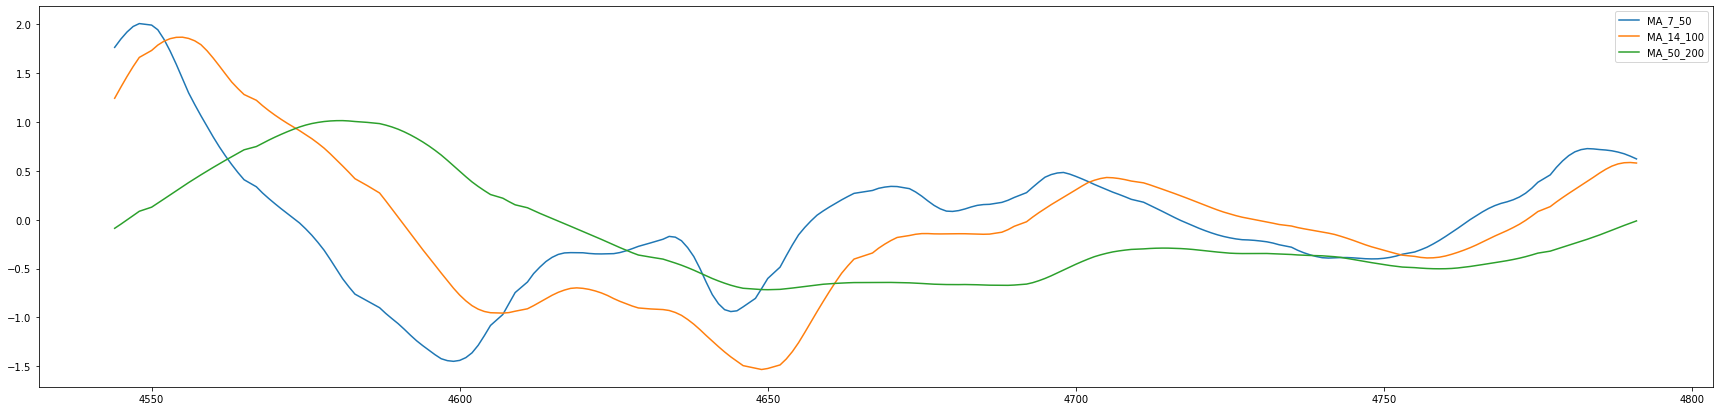

In [567]:
final_frame.iloc[:,:][["MA_7_50","MA_14_100","MA_50_200"]].plot(figsize=(30,7))

In [568]:
all_locations = get_locations(final_frame)

In [569]:
all_locations

[[29, 104, 158, 202], [40, 133, 164, 209]]

In [570]:
first_transactions = get_transactions(final_frame, "rec_1", get_locations(final_frame)[0])

In [571]:
first_transactions = update_transaction_list_thresholdBased(final_frame, first_transactions, 0.02)

In [572]:
second_transactions = get_transactions(final_frame, "rec_2", get_locations(final_frame)[1])

In [573]:
second_transactions = update_transaction_list_thresholdBased(final_frame, second_transactions, 0.02)

In [574]:
first_transactions

[[0, 3], [104, 113]]

In [575]:
first_returns = returns(final_frame, first_transactions)
first_returns

[-0.03310146765380531, -0.02518021501085034]

In [576]:
second_transactions

[[0, 3], [133, 136]]

In [577]:
second_returns = returns(final_frame, second_transactions)
second_returns

[-0.03310146765380531, -0.02289552733035313]

In [578]:
first_cum_return = prod(first_returns)
second_cum_return  = prod(second_returns)

In [579]:
first_cum_return

0.9425518194080419

In [580]:
second_cum_return

0.9447608805731841

In [581]:
duration_1 = sum([t[1]-t[0] for t in first_transactions])
duration_1

12

In [582]:
duration_2 = sum([t[1]-t[0] for t in second_transactions])
duration_2

6

In [583]:
total_duration = final_frame.shape[0]
total_duration

229

In [584]:
pow(((first_cum_return + second_cum_return) / 2), 
    (total_duration / ((duration_1 + duration_2) / 2)))

0.22864032558303898

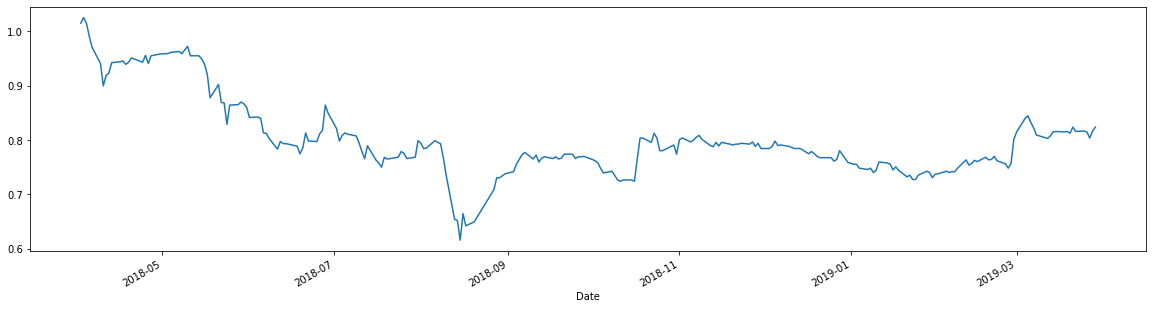

In [585]:
sm.plot_wealth_index(stock_name, "31-03-2018", "31-03-2019")